<a href="https://colab.research.google.com/github/JeFFich/Math_Programming/blob/main/%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B72.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns

Возьмем те же данные о сделках компании Boeing на поставку самолетов в различные страны в период с 1958 по 2022 года. Группировка и сегментация останутся аналогичными

In [ ]:
df = pd.read_csv('/content/cleanedOrdersBoeing (1).csv')

df.head()

,Unnamed: 0,country,customer,delivery_year,engine,model,month,year,region,delivery_total,order_total,unfilled_orders
0,0,Afghanistan,Ariana Afghan Airlines,1968,PW,727,Mar,1968,Central Asia,1,1,0
1,1,Afghanistan,Ariana Afghan Airlines,1970,PW,727,Apr,1969,Central Asia,1,1,0
2,2,Afghanistan,Ariana Afghan Airlines,1979,GE,DC-10,Sep,1978,Central Asia,1,1,0
3,4,Algeria,Air Algerie,1974,PW,727,Jan,1974,Africa,1,1,0
4,5,Algeria,Air Algerie,1974,PW,737-200,Jan,1974,Africa,1,1,0


Поля датасета:



*   ***country*** - Страна покупателя самолетов
*   ***customer*** - Клиент-авиакомпания
*   ***delivery_year*** - год доставки самолета
*   ***engine*** - мотор, установленный в самолете
*   ***model*** - модель самолета
*   ***month*** - месяц поставки
*   ***year*** - год заключения сделки
*   ***delivery_total*** - общее количество доставленных самолетов
*   ***order_total*** - общее количество заказанных самолетов
*   ***unfilled_orders*** - число недоставленных по изначальному заказу самолетов



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8002 non-null   int64 
 1   country          8002 non-null   object
 2   customer         8002 non-null   object
 3   delivery_year    8002 non-null   int64 
 4   engine           8002 non-null   object
 5   model            8002 non-null   object
 6   month            8002 non-null   object
 7   year             8002 non-null   int64 
 8   region           8002 non-null   object
 9   delivery_total   8002 non-null   int64 
 10  order_total      8002 non-null   int64 
 11  unfilled_orders  8002 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 750.3+ KB


Вновь введем другую метрику - ***задержка доставки*** (***delivery_lag***); численно она будет равна разности между годом оформления заказа и годом его получения

In [ ]:
df['delivery_lag'] = df['delivery_year'] - df['year']

Введем в рассмотрение три временных сегмента заказов:



1.   ***Ранние*** - заказы совершенные в период с **1958** по **1980** годы
2.   ***Срединные*** - заказы совершенные в период с **1981** по **2000** годы
3.   ***Позднейшие*** - заказы совершенные в период с **2001** по **2022** годы



In [ ]:
early_years_df = (
    df
    .loc[df['delivery_year'] <= 1980]
    .groupby('country')['delivery_total', 'order_total', 'delivery_lag']
    .sum()
    .reset_index()
)

middle_years_df = (
    df
    .loc[(1980 < df['delivery_year']) & (2000 >= df['delivery_year'])]
    .groupby('country')['delivery_total', 'order_total', 'delivery_lag']
    .sum()
    .reset_index()
)

late_years_df = (
    df
    .loc[2000 < df['delivery_year']]
    .groupby('country')['delivery_total', 'order_total', 'delivery_lag']
    .sum()
    .reset_index()
)

Вообще, к огромному сожалению, в данном датасете **отсутствуют какие-либо непрерывные показатели** - и кол-во заказанных самолетов, и кол-во доставленных, и временная задержка - все эти показатели измеряются целыми неотрицательными числами. Поэтому, формально мы **не можем применять тот же критерий Колмогорова**. Но давайте попробуем все же *представить метрику с наибольшим числом различных значений как непрерывную случайную величину и посмотреть, что мы получим *

# Проверка на однородность

In [ ]:
df.groupby('country')['delivery_total'].sum().nunique()

72

In [ ]:
df.groupby('country')['order_total'].sum().nunique()

72

In [ ]:
df.groupby('country')['delivery_lag'].sum().nunique()

69

Уникальных значений немного больше у метрики ***delivery_total***, так что предположим, что она имеет непрерывное распределение. При помощи *двухвыборочного теста Колмогорова* проверим, одинаково ли распределен этот показатель для различных сегментов

In [ ]:
st.ks_2samp(early_years_df['delivery_total'], middle_years_df['delivery_total'])

KstestResult(statistic=0.09796586392331073, pvalue=0.7153121594215881, statistic_location=23, statistic_sign=1)

In [ ]:
st.ks_2samp(middle_years_df['delivery_total'], late_years_df['delivery_total'])

KstestResult(statistic=0.13573442706998207, pvalue=0.34930712851922147, statistic_location=11, statistic_sign=1)

In [ ]:
st.ks_2samp(early_years_df['delivery_total'], late_years_df['delivery_total'])

KstestResult(statistic=0.16112802859790812, pvalue=0.18209839720968296, statistic_location=20, statistic_sign=1)

По результатам всех парных проверок, получаем, что **во всех сегментах это распределение одинаково**. Попробуем *визуально подтвердить это, посмотрев на гистограммы*

<Axes: xlabel='delivery_total', ylabel='Count'>

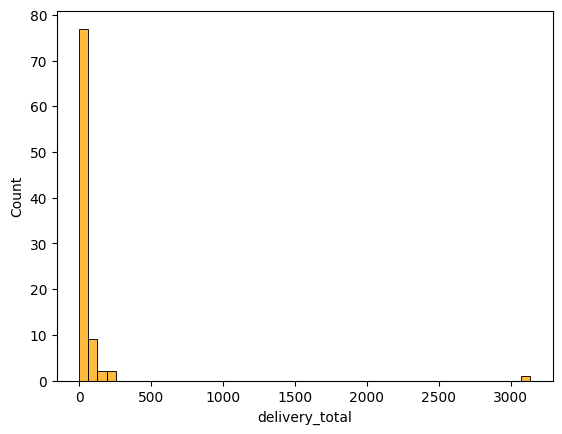

In [ ]:
sns.histplot(early_years_df['delivery_total'], color='orange', bins=50)

<Axes: xlabel='delivery_total', ylabel='Count'>

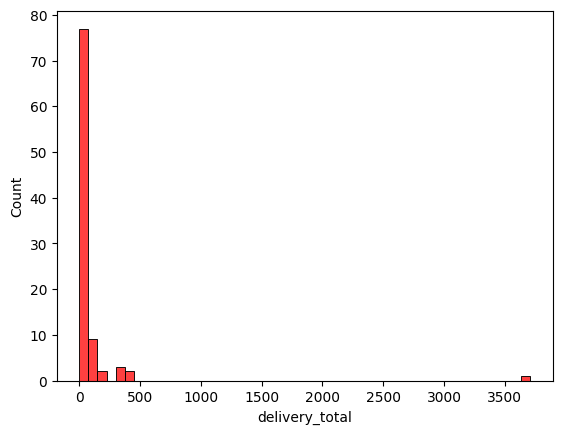

In [ ]:
sns.histplot(middle_years_df['delivery_total'], color='red', bins=50)

<Axes: xlabel='delivery_total', ylabel='Count'>

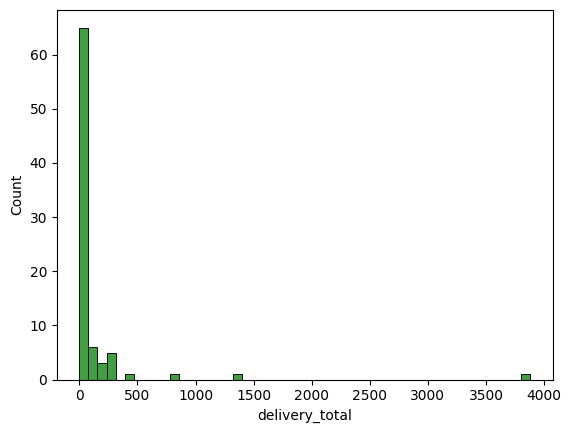

In [ ]:
sns.histplot(late_years_df['delivery_total'], color='green', bins=50)

Сразу бросаются в глаза **серьёзные различия не только в частотах, но и в хвостах**. В силу *неправомерного применения критерия Колмогорова ранее*, можно сказать, что *распределения поставок в первых двух сегментах скорее всего все же отличаются от третьего*, а между *первым и вторым различия тоже есть но они несколько меньше*

Теперь проверим на однородность распределения задержки доставки по сегментам. Так как **размеры сегоментов различны, то использование критерия Пирсона будет достаточно затруднительным**. Поэтому будем использовать *критерий Манна-Уитни*

In [ ]:
st.mannwhitneyu(early_years_df['delivery_lag'], middle_years_df['delivery_lag'])

MannwhitneyuResult(statistic=3899.0, pvalue=0.29877874165598317)

In [ ]:
st.mannwhitneyu(middle_years_df['delivery_lag'], late_years_df['delivery_lag'])

MannwhitneyuResult(statistic=2572.0, pvalue=9.275965599645297e-05)

In [ ]:
st.mannwhitneyu(early_years_df['delivery_lag'], late_years_df['delivery_lag'])

MannwhitneyuResult(statistic=1982.5, pvalue=6.31812417854995e-08)

Как можно увидеть, *в случае первых двух сегментов гипотеза об однородности не отвергается*, а *для третьего сегмента - отвергается* (то есть **распределение задержки в поздние годы статистически сильно отличается от остальных**). Тем не менее, если визуально оценить гистограммы метрики у первых двух сегментов, то они *будут достаточно сильно различаться*.

<Axes: xlabel='delivery_lag', ylabel='Count'>

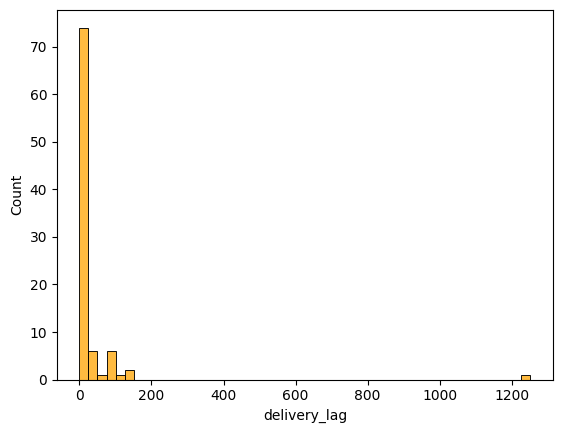

In [ ]:
sns.histplot(early_years_df['delivery_lag'], color='orange', bins=50)

<Axes: xlabel='delivery_lag', ylabel='Count'>

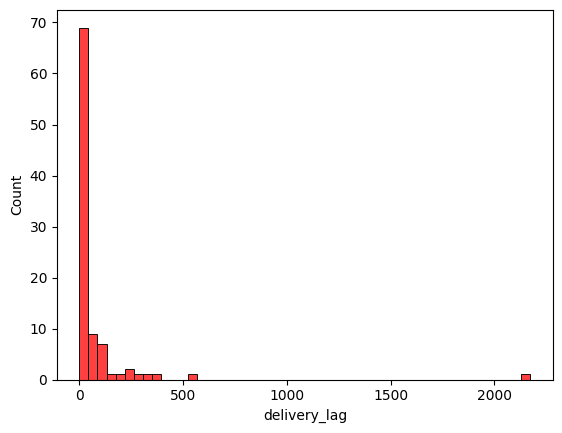

In [ ]:
sns.histplot(middle_years_df['delivery_lag'], color='red', bins=50)

# Проверка на равенство медиан

Раз уж при проверке **гипотез об однородности распределений показателя *delivery_total* нелуевая гипотеза везде не отвергалась** (невзирая на упомянутую ранее некоторую неправомерность применения критерия Колмогорова), то попробуем применить здесь*** критерий Манна-Уитни*** для *проверки на равенство медиан данного показателя для разных сегментов*

In [ ]:
st.mannwhitneyu(early_years_df['delivery_total'], middle_years_df['delivery_total'])

MannwhitneyuResult(statistic=4205.5, pvalue=0.8451584551126978)

In [ ]:
st.mannwhitneyu(middle_years_df['delivery_total'], late_years_df['delivery_total'])

MannwhitneyuResult(statistic=3276.5, pvalue=0.06629468861965908)

In [ ]:
st.mannwhitneyu(early_years_df['delivery_total'], late_years_df['delivery_total'])

MannwhitneyuResult(statistic=3056.0, pvalue=0.029907364152849482)

Можно заметить, что для соседних пар сегментов *гипотеза о равенстве медиан не отвергается*, а для *раннего и позднего сегментов - отвергается*. При этом значение p-уровня во втором сравнении также *достаточно близко к критическому* (особенно по сравнению с первым); вспоминая о большой вероятности наличия неоднородности в распределениях, можно предположить что **медиана статистически отличается в третьем сегменте, а в первом и втором - нет**

Перейдем к дискретной метрике **delivery_lag**. Так как в предыдущем разделе мы *отвергли гипотезу об однородности всех трех сегментов*, то попробуем использовать какой-нибудь другой тест для проверки равенства медиан. Основная проблема заключена в том, что **выборки не являются связаными и имеют различный объем**. Предлагается **урезать выборки до меньшей из длин и попробовать применить двухвыборочный *критерий Уилкоксона* с двухсторонней альтернативой**; при этом будем *брать случайную выборку без повторений несколько раз и считать кол-во случаев, когда нулевая гипотеза о равенстве медиан отвергалас*ь. Если это количество **больше заданного критиеского уровня 0.05**, то будем *отвергать нулевую гипотезу о равенстве медиан для исходных выборок* (своего рода аналог бутстрапа)

In [ ]:
def pseudo_wilcox(df1, df2, alpha = 0.05):
  """
    Функция проверки гипотезы о равенстве медиан для выборок разного объема (df1.len < df2.len)
  """
  c = 0
  for _ in range(1000):
    rand_sample = np.random.choice(df2, size = df1.shape[0], replace = False) # Извлечение случайной подвыборки требуемого объема
    if st.wilcoxon(df1, rand_sample).pvalue < alpha: # Применеие критерия Уилкоксона и подсчет кол-ва отвержений гипотез
      c += 1

  return c / 1000 # Возвращение аналога ошибки первого рода

In [ ]:
pseudo_wilcox(early_years_df['delivery_lag'], middle_years_df['delivery_lag'])

0.146

In [ ]:
pseudo_wilcox(late_years_df['delivery_lag'], middle_years_df['delivery_lag'])

0.999

In [ ]:
pseudo_wilcox(late_years_df['delivery_lag'], early_years_df['delivery_lag'])

1.0

Во всех трех случаях **ошибка первого рода оказалась выше критического уровня**, следовательно мы должны отвергнуть *гипотезы о равенстве медиан*.

# Проверка гипотез бутстрапом

Построим Эфроновы доверительные интервалы для медиан различных сегментов и сопоставим их друг с другом

In [ ]:
def bootstrap_interval(rvs, stat=np.median, alpha=0.05):
  """
      Построение эфронова доверительного интервала для выбранной статистики stat (передаваемой в виде функции) по выборке rvs на уровне доверия 1 - alpha
  """
  n = rvs.shape[0]
  distribution_lst = []
  for _ in range(100):
    a_ = np.random.choice(rvs, size=n, replace=True) # Получение подвыборки
    distribution_lst.append(stat(a_)) # Расчет искомой статистики для подвыборки и добавление в псевдораспределение

  return np.percentile(distribution_lst, q=[alpha / 2 * 100, (1 - alpha / 2) * 100]) # Возвращение требуемого доверительного интервала по полученному псевдораспределению статистики

Сперва построим для метрики ***delivery_total***

In [ ]:
bootstrap_interval(early_years_df['delivery_total'])

array([ 7.   , 14.525])

In [ ]:
bootstrap_interval(middle_years_df['delivery_total'])

array([ 6.2375, 16.    ])

In [ ]:
bootstrap_interval(late_years_df['delivery_total'])

array([13., 25.])

Можно заметить что **интервалы у первых двух сегментов значительно пересекаются** (вернее первый может вообще целиком лежать во втором), что *свидетельствует о большой вероятности совпадения медиан для них*; у **третьего же сегмента пересечение с остальными сегментами достаточно мало**, а значит вероятность совпадения достаточно низка (то есть можно *гипотезу о равенстве отвергнуть*)

Теперь для метрики ***delivery_lag***

In [ ]:
bootstrap_interval(early_years_df['delivery_lag'])

array([4., 9.])

In [ ]:
bootstrap_interval(middle_years_df['delivery_lag'])

array([ 4.5  , 12.525])

In [ ]:
bootstrap_interval(late_years_df['delivery_lag'])

array([21., 44.])

И снова: **интервалы для первых двух сегментов значительно пересекаются** (что может *свидетельствовать о совпадении медиан*), **а у третьего сегмента вообще не имеет пересечения с остальными** (следовательно *гипотезу о равенстве медиан можно однозначно отвергнуть*)

Вообще не очень понятно, как конкретно применять бутстрап при проверке гипотез однородности; в моем понимании *этот метод в первую очередь подходит для проверки гипотез о конкретных статистиках, а не о функциях распределения в целом*. Наверное, можно как-то попробовать посравнивать доверительные интервалы для квантилей распределения, но какие-то конкретные действия, как бы это можно было осуществить, мне не приходят на ум. Поэтому, я предлагаю несколько другой вариант применения бутстрапа (аналог того что делалось выше при применении критерия Уилкоксона): ***будем извлекать произвольные выборки, применять для них критерий Манна-Уитни и считать долю отвергнутых гипотез (аналог ошибки первого рода)***. Затем достаточно будет *сравнить полученный анлог с заданной ошибкой первого рода, и если первая будет больше, то нулевую гипотезу отвергнуть*.  

In [ ]:
def bootstrap_cdf_check(df1, df2, alpha = 0.05):
  """
    Функция вычисления ошибки первого рода для проверки гипотезы однородности бустрапом (вернее подобием)
  """
  c = 0 # Счетчик отвергнутых гипотез
  for _ in range(1000):
    rand_sample1 = np.random.choice(df1, size = df1.shape[0], replace = True) # Первая псевдовыборка
    rand_sample2 = np.random.choice(df2, size = df2.shape[0], replace = True) # Вторая псевдовыборка
    if st.mannwhitneyu(rand_sample1, rand_sample2).pvalue < alpha: # Критерий Манна-Уитни для принятия или отвержения гипотезы
      c += 1

  return c / 1000

Применим этот подход для метрики ***delivery_total***

In [ ]:
for _ in range(10):
  print(bootstrap_cdf_check(early_years_df['delivery_total'], middle_years_df['delivery_total']))

0.04
0.052
0.063
0.046
0.05
0.08
0.056
0.051
0.054
0.044


In [ ]:
for _ in range(10):
  print(bootstrap_cdf_check(late_years_df['delivery_total'], middle_years_df['delivery_total']))

0.432
0.467
0.475
0.459
0.438
0.468
0.466
0.444
0.492
0.453


In [ ]:
for _ in range(10):
  print(bootstrap_cdf_check(early_years_df['delivery_total'], late_years_df['delivery_total']))

0.581
0.583
0.58
0.57
0.578
0.575
0.604
0.596
0.575
0.564


Впринципе, полученные результаты **во многом согласуются с теми выводами, которые были сделаны при сопоставлении гистограмм распределений**. Так, *первый и второй сегмент находятся "на грани" между отвержением и принятием гипотез* (возвращаемый аналог ошибки первого рода в основном колеблется на уровне 0.4-0.6). Для сравнений же с третьим сегментом *возвращаемый показатель значительно превосходит заданный уровень значимости*, а значит *принятие гипотезы об однородности распредлений невозможно*.

Теперь применим для ***delivery_lag***

In [ ]:
for _ in range(10):
  print(bootstrap_cdf_check(early_years_df['delivery_lag'], middle_years_df['delivery_lag']))

0.191
0.171
0.185
0.191
0.184
0.176
0.189
0.169
0.156
0.181


In [ ]:
for _ in range(10):
  print(bootstrap_cdf_check(late_years_df['delivery_lag'], middle_years_df['delivery_lag']))

0.975
0.98
0.983
0.979
0.977
0.988
0.988
0.976
0.979
0.983


In [ ]:
for _ in range(10):
  print(bootstrap_cdf_check(late_years_df['delivery_lag'], early_years_df['delivery_lag']))

1.0
1.0
1.0
1.0
1.0
1.0
0.999
1.0
1.0
1.0


В данном случае** отвергаются сразу все три гипотезы**; при этом, когда мы выше применяли *критерий Манна-Уитни* для двух первых сегментов целиком, то *отвержение гипотезы мы не получали* (однако по гистограммам отличия прослеживались). При сравнении с третьим сегментам *отвержения происходят настолько часто, что гипотезу об однородности принять ну никак нельзя*.

# Некоторое послесловие (пункт 3 из дз)

Вообще, данный датасет (по крайней мере при выбранной сегментации и групировке) является **крайне неудобным для применения стандартных тестов**: *распределения метрик сильно скошены влево*, *имеются явные выбросы и пробелы*; *записей в сегментах получилось не очень много, при этом объемы и структура сегментов различны по каждой выборке*; *сами метрики исключительно дискретные*. Поэтому в данном конретном случае **применение рассмотренных на лекции критериев крайне затруднительно**: *критерий Колмогорова не применим в силу дискретности метрик*, *критерии Пирсона и Уилкоксона - в силу различного состава выборок*, *критерий Манна-Уитни - в силу наличия существенных различий в функциях распределений*. Поэтому в данном случае **куда более действенным и мощным будет бутстрап**, с оговоркой о непонятности (как минимум моей) его применения для проверки однородности. Тем не менее, *во многих ситуациях даже не очень правомерное применение стандартных критериев давало результаты, аналогичные бутстрапу*.



In [ ]:
!jupyter nbconvert --to html '/content/Проверка_гипотез2.ipynb'

[NbConvertApp] Converting notebook /content/Проверка_гипотез2.ipynb to html
[NbConvertApp] Writing 748631 bytes to /content/Проверка_гипотез2.html
